In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For text cleaner function
from nltk.corpus import stopwords
import string
from nltk.stem import WordNetLemmatizer
from string import punctuation
import re

In [4]:
# import DFs
question_df = pd.read_csv('../0.Datasets/raw/FiQA_train_question_final.tsv', sep = '\t', index_col = 0)
map_df = pd.read_csv('../0.Datasets/raw/FiQA_train_question_doc_final.tsv', sep = '\t', index_col = 0)
doc_df = pd.read_csv('../0.Datasets/raw/FiQA_train_doc_final.tsv', sep = '\t', index_col = 0)

# Consolidated dataset findings (explanation below):
- Number of documents: 57638, Number of mappings: 17110, Number of questions: 6648
- docid starts from 3 and ends at 599987, but there are only 57638 documents - there are some docid-s that are missing from the running sequence
- 1 question can be mapped to multiple documents
- 1 document is only mapped to 1 question

# Investigate mapping btw questions and docs

Number of documents: 57638
Number of mappings: 17110
Number of questions: 6648


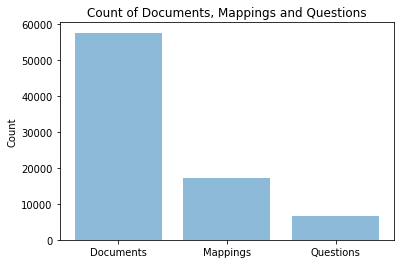

In [7]:
# Count of Documents and Questions
print(f'Number of documents: {doc_df.shape[0]}')
print(f'Number of mappings: {map_df.shape[0]}')
print(f'Number of questions: {question_df.shape[0]}')

objects = ('Documents', 'Mappings','Questions')
y_pos = np.arange(len(objects))
performance = [doc_df.shape[0], map_df.shape[0], question_df.shape[0]]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Count')
plt.title('Count of Documents, Mappings and Questions')

plt.show()

Significantly more documents than mappings - this means that some questions are mapped to multiple documents.

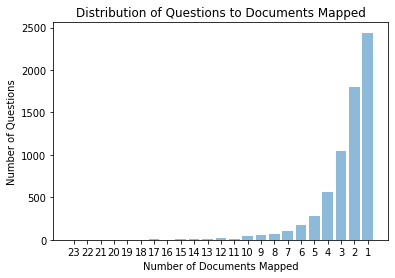

In [8]:
# Distribution of questions to number of documents mapped
qn_num_docmaps = {}
for v in dict(map_df['qid'].value_counts()).values():
    if v not in qn_num_docmaps:
        qn_num_docmaps[v] = 1
    else:
        qn_num_docmaps[v] += 1


objects = [k for k in qn_num_docmaps.keys()]
y_pos = np.arange(len(objects))
performance = [v for v in qn_num_docmaps.values()]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Number of Questions')
plt.xlabel('Number of Documents Mapped')
plt.title('Distribution of Questions to Documents Mapped')

plt.show()

From the graph above, we can see that out of 6648 questions, ~2500 of them are mapped to 1 document. Some questions are mapped to multiple documents, spanning from being mapped to 1 document all the way to 23 documents.

In [9]:
# Distribution of documents to questions mapped
map_df['docid'].value_counts()

559105    1
542321    1
345410    1
118083    1
331598    1
         ..
231727    1
201447    1
431459    1
324331    1
77818     1
Name: docid, Length: 17110, dtype: int64

We can see from above that all documents only have 1 question mapped to it.

In [10]:
map_df['docid'].value_counts()

559105    1
542321    1
345410    1
118083    1
331598    1
         ..
231727    1
201447    1
431459    1
324331    1
77818     1
Name: docid, Length: 17110, dtype: int64

# Investigate questions df

I just used a random text cleaner function from an old project, can replace it when we finalize what we want to include in our cleaner function.

In [11]:
# Stop word list to filter noise in bag of words
stop_list = stopwords.words('english')

WNL = WordNetLemmatizer()

punct_list = [punctuation[p] for p in range(len(punctuation))]
add_stop_words = ['class', 'div', 'description__text', 'ul', 
                  'li', 'br', 'ul', 'job', 'description', 'rich', 
                  'strong', 'to', 'apply', 'visit', 'the', 'and',
                  'make', 'at', 'you', 'we', 'our', 'would', 'via',
                  'pte', 'ltd', 'us', 'please', 'lt', 'weight', 'gt',
                  'span', 'em']

stop_list += punct_list + add_stop_words

def cleaner(x):
    output = []
    x = re.sub(r'<[\sa-zA-Z0-9=\-_/"]+>', ' ', x)
    for w in x.split():
        curr_word = WNL.lemmatize(w)
        curr_word = curr_word.lower()
        curr_word = re.sub(r'[^\w\s]', '', curr_word)
        if curr_word not in stop_list:
            output.append(curr_word)
    return ' '.join(output)

In [12]:
# Clean questions
question_df['clean_question'] = question_df.apply(lambda x: cleaner(x['question']), axis = 1)

# Get length of cleaned questions
question_df['question_length'] = question_df.apply(lambda x: len([i for i in x['clean_question'].split()]), axis = 1)
question_df.head()

,qid,question,timestamp,clean_question,question_length
0,0,What is considered a business expense on a bus...,Nov 8 '11 at 15:14,considered business expense business trip,5
1,1,Claiming business expenses for a business with...,May 13 '14 at 13:17,claiming business expense business income,5
2,2,Transferring money from One business checking ...,Jan 20 '16 at 20:31,transferring money one business checking anoth...,8
3,3,Having a separate bank account for business/in...,Mar 1 at 0:24,separate bank account businessinvesting busine...,6
4,4,Business Expense - Car Insurance Deductible Fo...,Mar 4 at 0:26,business expense car insurance deductible acc...,9


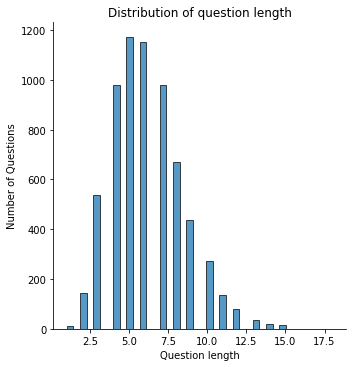

In [13]:
# Distribution of question length
sns.displot(question_df['question_length'])
plt.ylabel('Number of Questions')
plt.xlabel('Question length')
plt.title('Distribution of question length')
plt.show()

Most questions fall between 4 to 8 words.